In [ ]:
#default_exp vision.rect_augment
#default_cls_lvl 3

# Rectangular computer vision augmentation

> Transforms to apply data augmentation to rectangular images

In [ ]:
#export
from local.imports import *
from local.test import *
from local.core import *
from local.data.transform import *
from local.data.pipeline import *
from local.data.source import *
from local.data.core import *
from local.vision.core import *
from local.vision.augment import *
from local.data.external import *
from local.notebook.showdoc import show_doc

## SortARSampler

- resize large images
- sort by size (size group of size n=1000//bs\*bs) and AR
- shufflish

In [ ]:
path = untar_data(URLs.PETS)
items = get_image_files(path/'images')
labeller = RegexLabeller(pat = r'/([^/]+)_\d+.jpg$')
split_idx = RandomSplitter()(items)
tfms = [PILImage.create, [labeller, Categorize()]]
tds = TfmdDS(items, tfms)
im = tds[0][0]; im.shape

(500, 375)

In [ ]:
#export
class SortARSampler(BatchSampler):
    def __init__(self, ds, items=None, bs=32, grp_sz=1000, shuffle=False, drop_last=False):
        if not items: items=ds.items
        self.shapes = [Image.open(it).shape for it in items]
        self.sizes = [h*w for h,w in self.shapes]
        self.ars = [h/w for h,w in self.shapes]
        self.ds,self.grp_sz,self.bs,self.shuffle,self.drop_last = ds,round_multiple(grp_sz,bs),bs,shuffle,drop_last
        self.grp_sz = round_multiple(grp_sz,bs)
        
        # reverse argsort of sizes
        idxs = [i for i,o in sorted(enumerate(self.sizes), key=itemgetter(1), reverse=True)]
        # create approx equal sized groups no larger than `grp_sz`
        grps = [idxs[i:i+self.grp_sz] for i in range(0, len(idxs), self.grp_sz)]
        # sort within groups by aspect ratio
        self.grps = [sorted(g, key=lambda o:self.ars[o]) for g in grps]

    def __iter__(self):
        grps = self.grps
        if self.shuffle: grps = [shufflish(o) for o in grps]
        grps = [g[i:i+self.bs] for g in grps for i in range(0, len(g), self.bs)]
        if self.drop_last and len(grps[-1])!=self.bs: del(grps[-1])
        # Shuffle all but first (so can have largest first)
        if self.shuffle: grps = random.sample(grps[1:], len(grps)-1) + [grps[0]]
        return iter(grps)

    def __len__(self): return (len(self.ds) if self.drop_last else (len(self.ds)+self.bs-1)) // self.bs

In [ ]:
samp = SortARSampler(tds, shuffle=False)
test_eq(len(samp), (len(tds)-1)//32+1)

In [ ]:
itr = iter(samp)
first = next(itr)
i = 1
for last in itr: i += 1
test_eq(len(samp), i)
first = [tds[i][0] for i in first]
last  = [tds[i][0] for i in last]
#big images are first, smaller images last
assert np.mean([im.n_px for im in last])*5 < np.mean([im.n_px for im in first])
#Higher aspect ratios are first
assert np.mean([im.aspect for im in last])*2 < np.mean([im.aspect for im in first])
#In a batch with similar aspect ratio
assert np.std([im.aspect for im in first]) < 0.1
assert np.std([im.aspect for im in last]) < 0.1

In [ ]:
samp = SortARSampler(tds, shuffle=True)
itr = iter(samp)
first = next(itr)
for last in itr: pass
first = [tds[i][0] for i in first]
last  = [tds[i][0] for i in last]
#In a batch with similar aspect ratio
assert np.std([im.aspect for im in first]) < 0.1
assert np.std([im.aspect for im in last]) < 0.1

## ResizeCollate

In [ ]:
#export
from torch.utils.data.dataloader import default_collate

In [ ]:
#export
class ResizeCollate(TfmdCollate):
    def __init__(self, tfms=None, collate_fn=default_collate, sz=None, is_fixed_px=False, max_px=512*512, round_mult=None,
                rand_min_scale=None, rand_ratio_pct=None): 
        super().__init__(tfms, default_collate)
        self.round_mult,self.is_fixed_px,self.max_px = round_mult,is_fixed_px,max_px
        self.is_rand = rand_min_scale or rand_ratio_pct
        if self.is_rand:
            self.inv_ratio = 1-ifnone(rand_ratio_pct, 0.10)
            self.resize = RandomResizedCrop(1, min_scale=ifnone(rand_min_scale, 0.25), as_item=False)
        else: self.resize = Resize(1, as_item=False)
        self.sz = None if sz is None else (sz, sz) if isinstance(sz, int) else sz
        
    def __call__(self, samples):
        if self.sz is None:
            if self.is_fixed_px: px = self.max_px
            else: px = min(self.max_px, max(L(o[0].shape[0]*o[0].shape[1] for o in samples)))
            ar = np.median(L(o[0].aspect for o in samples))
            sz = int(math.sqrt(px*ar)),int(math.sqrt(px/ar))
        else: sz,ar = self.sz,self.sz[1]/self.sz[0]
        if self.round_mult is not None: sz = round_multiple(sz, self.round_mult, round_down=True)
        if self.is_rand: self.resize.ratio = (ar*self.inv_ratio, ar/self.inv_ratio)
        return super().__call__(self.resize(o,size=sz) for o in samples)

In [ ]:
samp = SortARSampler(tds, shuffle=True, bs=16)
collate_fn = ResizeCollate(max_px=10000)
tdl = TfmdDL(tds, batch_sampler=samp, collate_fn=collate_fn, num_workers=0)
batch = tdl.one_batch()

test_eq(L(batch).mapped(type), (TensorImage,Tensor))
b,c,h,w = batch[0].shape
assert 9000<h*w<=10000
test_eq(b, 16)

In [ ]:
collate_fn = ResizeCollate(is_fixed_px=True, max_px=500000)
tdl = TfmdDL(tds, batch_sampler=samp, collate_fn=collate_fn, num_workers=0)
batch = tdl.one_batch()
b,c,h,w = batch[0].shape
assert 490000<h*w<=500000

In [ ]:
collate_fn = ResizeCollate(sz=128)
tdl = TfmdDL(tds, batch_sampler=samp, collate_fn=collate_fn, num_workers=0)
batch = tdl.one_batch()
test_eq(batch[0].shape[2:], [128,128])

In [ ]:
collate_fn = ResizeCollate(round_mult=32, max_px=10000)
tdl = TfmdDL(tds, batch_sampler=samp, collate_fn=collate_fn, num_workers=0)
batch = tdl.one_batch()
b,c,h,w = batch[0].shape
test_eq(h%32, 0)
test_eq(w%32, 0)
assert h*w<=10000

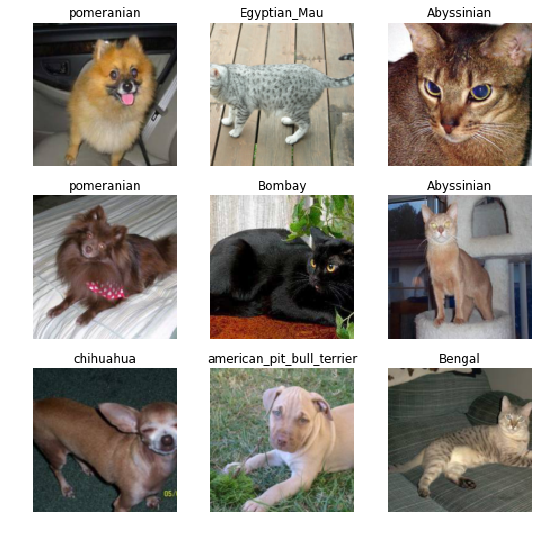

In [ ]:
collate_fn = ResizeCollate(sz=128, rand_min_scale=0.7)
tdl = TfmdDL(tds, batch_sampler=samp, collate_fn=collate_fn, num_workers=0)
_,axs = plt.subplots(3,3, figsize=(9,9))
tdl.show_batch(ctxs=axs.flatten())

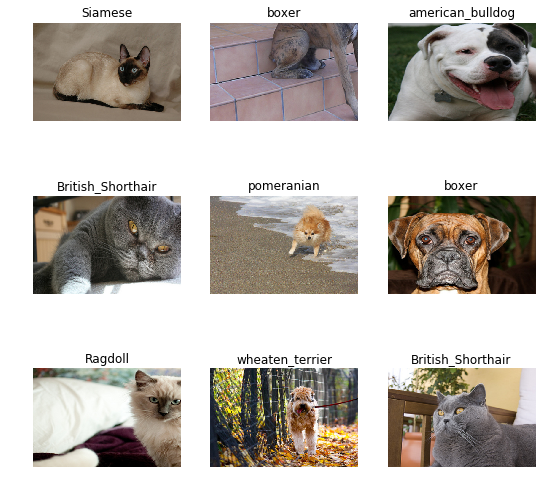

In [ ]:
collate_fn = ResizeCollate(rand_min_scale=0.25, rand_ratio_pct=0.3)
tdl = TfmdDL(tds, batch_sampler=samp, collate_fn=collate_fn, num_workers=0)
_,axs = plt.subplots(3,3, figsize=(9,9))
tdl.show_batch(ctxs=axs.flatten())

## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 01a_script.ipynb.
Converted 02_transforms.ipynb.
Converted 03_pipeline.ipynb.
Converted 04_data_external.ipynb.
Converted 05_data_core.ipynb.
Converted 06_data_source.ipynb.
Converted 07_vision_core.ipynb.
Converted 08_pets_tutorial.ipynb.
Converted 09_vision_augment.ipynb.
Converted 09a_rect_augment.ipynb.
Converted 10_data_block.ipynb.
Converted 11_layers.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 14_callback_schedule.ipynb.
Converted 15_callback_hook.ipynb.
Converted 16_callback_progress.ipynb.
Converted 17_callback_tracker.ipynb.
Converted 18_callback_fp16.ipynb.
Converted 30_text_core.ipynb.
Converted 90_notebook_core.ipynb.
Converted 91_notebook_export.ipynb.
Converted 92_notebook_showdoc.ipynb.
Converted 93_notebook_export2html.ipynb.
Converted 94_index.ipynb.
Converted 95_synth_learner.ipynb.
